Download and Extract Dataset

In [ ]:
import os
import requests
import zipfile

# URLs for datasets
urls = {
    "DB1": "http://bias.csr.unibo.it/fvc2004/Downloads/DB1_B.zip",
    "DB2": "http://bias.csr.unibo.it/fvc2004/Downloads/DB2_B.zip",
    "DB3": "http://bias.csr.unibo.it/fvc2004/Downloads/DB3_B.zip",
    "DB4": "http://bias.csr.unibo.it/fvc2004/Downloads/DB4_B.zip"
}

# Directory to save datasets
data_dir = "/content/fingerprint_datasets"
os.makedirs(data_dir, exist_ok=True)

# Function to download and extract dataset
def download_and_extract(url, save_dir):
    # Create a folder for each database to store the extracted files separately
    db_name = os.path.splitext(os.path.basename(url))[0]
    db_save_dir = os.path.join(save_dir, db_name)
    os.makedirs(db_save_dir, exist_ok=True)

    zip_path = os.path.join(db_save_dir, os.path.basename(url))

    if not os.path.exists(zip_path):
        print(f"Downloading {url}...")
        response = requests.get(url)
        with open(zip_path, 'wb') as f:
            f.write(response.content)
        print(f"Downloaded {zip_path}.")
    else:
        print(f"{zip_path} already exists.")

    # Extract the zip file to the corresponding directory
    extract_dir = os.path.splitext(zip_path)[0]
    if not os.path.exists(extract_dir):
        print(f"Extracting {zip_path}...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
        print(f"Extracted to {extract_dir}.")
    else:
        print(f"{extract_dir} already extracted.")

    return extract_dir

# Download and extract all datasets into separate directories
extracted_dirs = {}
for db, url in urls.items():
    extracted_dirs[db] = download_and_extract(url, data_dir)

print(f"Datasets extracted to: {extracted_dirs}")


Downloaded /content/fingerprint_datasets/DB1_B/DB1_B.zip.
Extracting /content/fingerprint_datasets/DB1_B/DB1_B.zip...
Extracted to /content/fingerprint_datasets/DB1_B/DB1_B.
Downloaded /content/fingerprint_datasets/DB2_B/DB2_B.zip.
Extracting /content/fingerprint_datasets/DB2_B/DB2_B.zip...
Extracted to /content/fingerprint_datasets/DB2_B/DB2_B.
Downloaded /content/fingerprint_datasets/DB3_B/DB3_B.zip.
Extracting /content/fingerprint_datasets/DB3_B/DB3_B.zip...
Extracted to /content/fingerprint_datasets/DB3_B/DB3_B.
Downloaded /content/fingerprint_datasets/DB4_B/DB4_B.zip.
Extracting /content/fingerprint_datasets/DB4_B/DB4_B.zip...
Extracted to /content/fingerprint_datasets/DB4_B/DB4_B.
Datasets extracted to: {'DB1': '/content/fingerprint_datasets/DB1_B/DB1_B', 'DB2': '/content/fingerprint_datasets/DB2_B/DB2_B', 'DB3': '/content/fingerprint_datasets/DB3_B/DB3_B', 'DB4': '/content/fingerprint_datasets/DB4_B/DB4_B'}


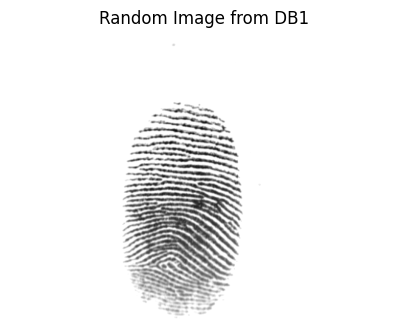

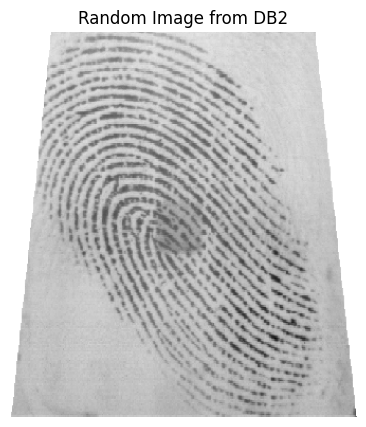

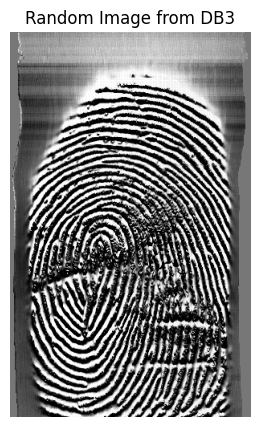

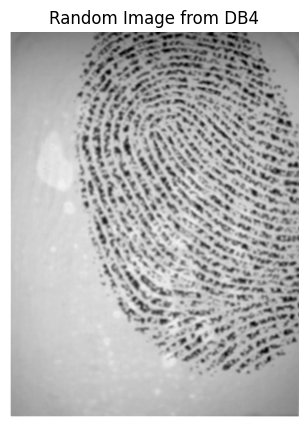

In [ ]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

# Function to show a random image from each database directory
def show_random_images(extracted_dirs):
    for db, db_path in extracted_dirs.items():
        # List all .tif files in the directory
        image_files = [f for f in os.listdir(db_path) if f.endswith('.tif')]

        if image_files:
            # Pick a random image file
            random_image_file = random.choice(image_files)
            random_image_path = os.path.join(db_path, random_image_file)

            # Open the image
            image = Image.open(random_image_path)

            # Display the image using matplotlib
            plt.figure(figsize=(5,5))
            plt.imshow(image, cmap='gray')
            plt.title(f"Random Image from {db}")
            plt.axis('off')
            plt.show()
        else:
            print(f"No images found in {db_path}")

# Show random images from each dataset
show_random_images(extracted_dirs)


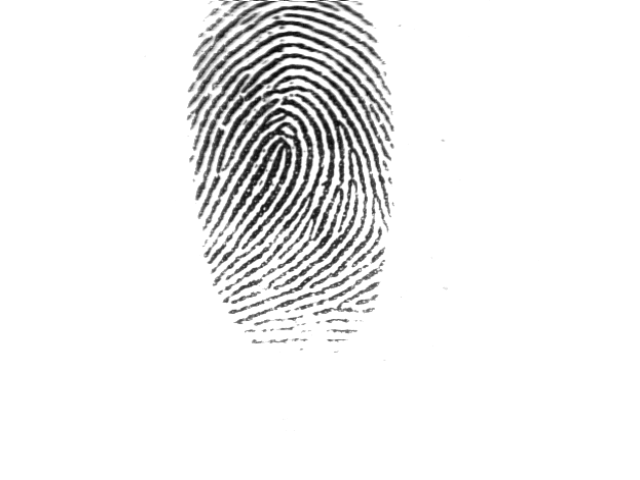

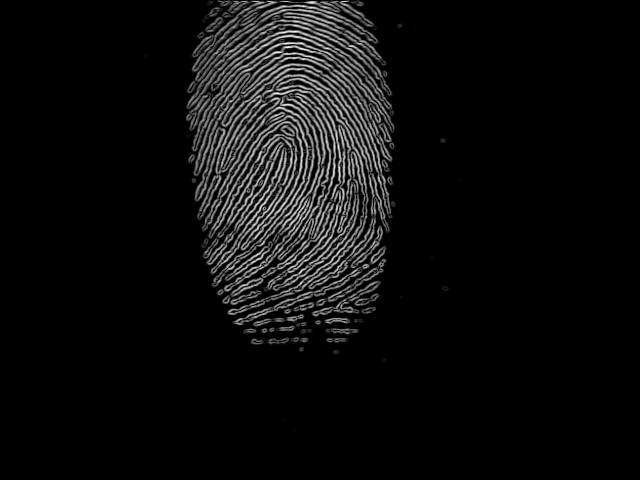

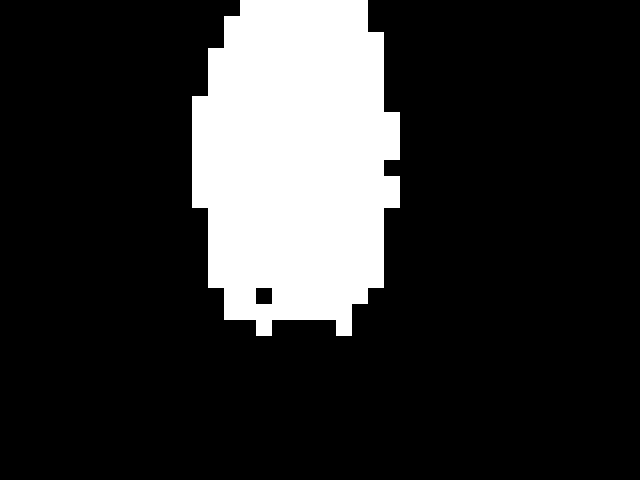

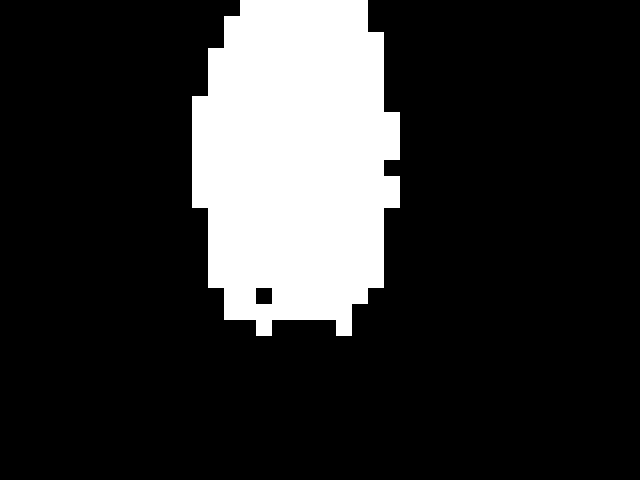

In [ ]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from google.colab.patches import cv2_imshow

# Pre-processing
def preprocess_image(image):
    # Sobel filtering
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(sobelx**2 + sobely**2)

    # Normalize gradient magnitude
    gradient_magnitude = cv2.normalize(gradient_magnitude, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # TopHat filtering
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    tophat = cv2.morphologyEx(gradient_magnitude, cv2.MORPH_TOPHAT, kernel)
    return tophat

# Feature extraction
def extract_features(blocks):
    features = []
    for block in blocks:
        variance = np.var(block)
        mean_diff = np.mean(block) - np.mean(blocks)
        # Additional gradient and frequency calculations would go here
        features.append([variance, mean_diff])
    return np.array(features)

# Segmentation
def segment_image(image, block_size):
    h, w = image.shape
    blocks = [
        image[i:i+block_size, j:j+block_size]
        for i in range(0, h, block_size)
        for j in range(0, w, block_size)
    ]
    features = extract_features(blocks)

    # K-means clustering
    kmeans = KMeans(n_clusters=2, random_state=42).fit(features)
    segmented = kmeans.labels_.reshape((h // block_size, w // block_size))

    return segmented

# Refinement with DBSCAN
def refine_segmentation(segmented, eps=0.5, min_samples=5):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(segmented.reshape(-1, 1))
    refined = dbscan.labels_.reshape(segmented.shape)
    return refined

# Main execution
if __name__ == "__main__":
    # Load grayscale fingerprint image
    image = cv2.imread("/content/fingerprint_datasets/DB1_B/DB1_B/103_1.tif", cv2.IMREAD_GRAYSCALE)

    # Preprocess image
    preprocessed_image = preprocess_image(image)

    # Perform segmentation
    block_size = 16  # Example block size
    segmented = segment_image(preprocessed_image, block_size)

    # Refine segmentation
    refined = refine_segmentation(segmented)

from google.colab.patches import cv2_imshow

# Display results
cv2_imshow(image)  # Original Image
cv2_imshow(preprocessed_image)  # Preprocessed Image
# Resize segmented and refined images to the original size
segmented_resized = cv2.resize(segmented.astype(np.uint8) * 255, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)
refined_resized = cv2.resize(refined.astype(np.uint8) * 255, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

# Display results
cv2_imshow(segmented_resized)  # Resized Segmented Image
cv2_imshow(refined_resized)  # Resized Refined Segmentation




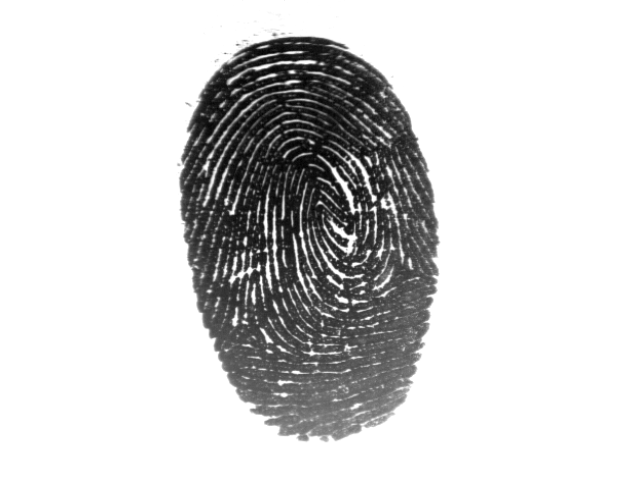

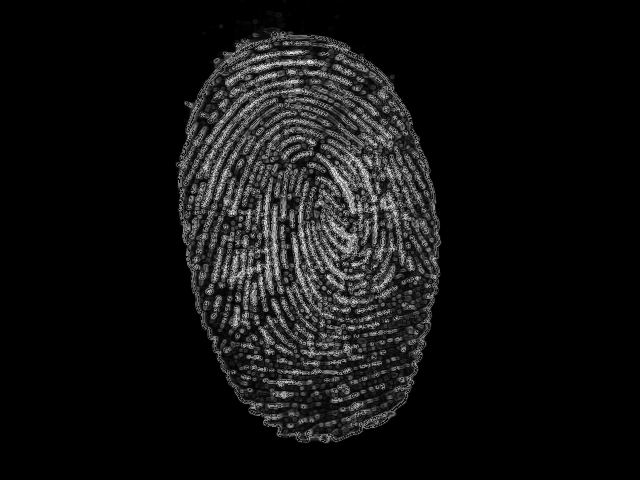

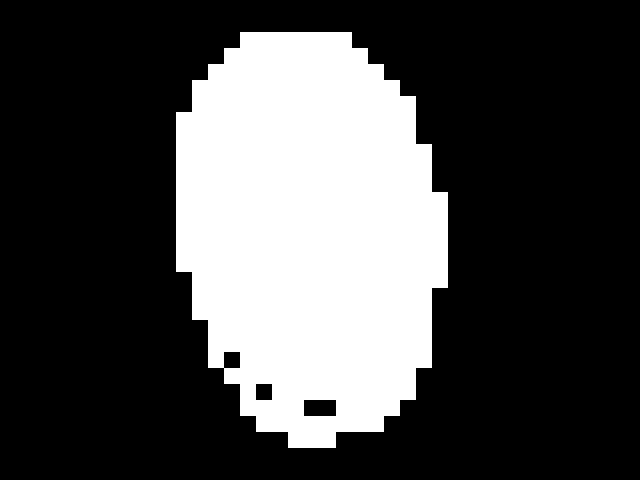

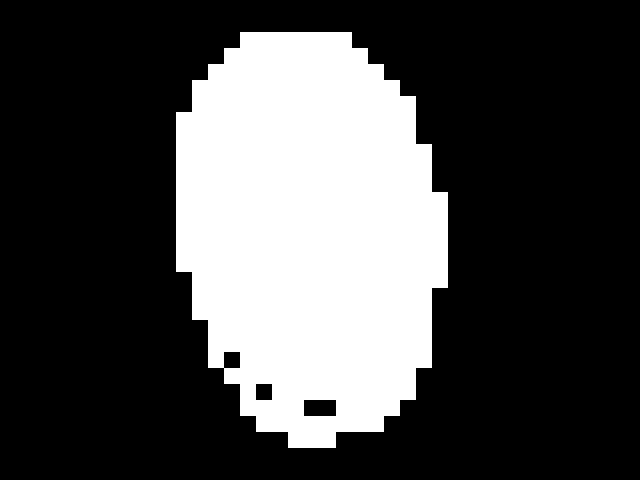

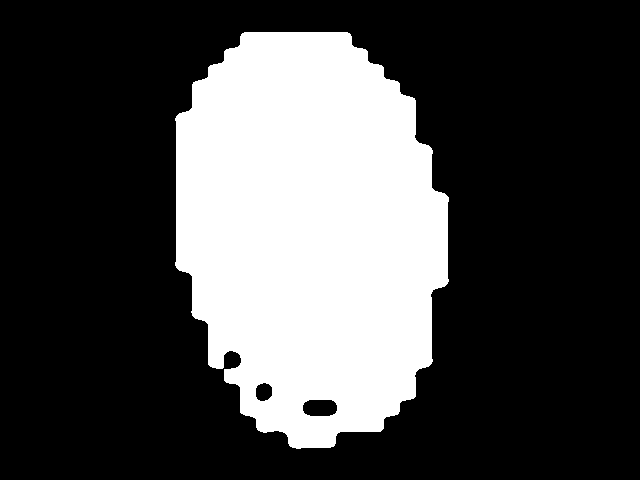

In [ ]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

# Feature extraction for each block
def extract_features(block):
    """Extract features from a block."""
    # 1. Variance
    variance = np.var(block)

    # 2. Difference of Mean
    local_mean = np.mean(block)
    global_mean = np.mean(block.flatten())
    diff_mean = local_mean - global_mean

    # 3. Gradient Coherence
    sobelx = cv2.Sobel(block, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(block, cv2.CV_64F, 0, 1, ksize=3)
    gx2 = np.mean(sobelx**2)
    gy2 = np.mean(sobely**2)
    gxy = np.mean(sobelx * sobely)
    coherence = np.sqrt((gx2 - gy2)**2 + 4 * gxy**2) / (gx2 + gy2 + 1e-8)

    # 4. Ridge Direction
    ridge_direction = 0.5 * np.arctan2(2 * gxy, gx2 - gy2)

    # 5. Energy Spectrum (via Fourier transform)
    fft = np.fft.fft2(block)
    energy_spectrum = np.sqrt(np.sum(np.real(fft)**2 + np.imag(fft)**2))

    return [variance, diff_mean, coherence, ridge_direction, energy_spectrum]

# Preprocessing
def preprocess_image(image):
    """Preprocess the image using Sobel and TopHat filters."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Sobel Filters
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    gradient = np.sqrt(sobelx**2 + sobely**2)
    gradient = np.uint8(gradient)

    # TopHat Filter
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
    tophat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, kernel)

    preprocessed = cv2.addWeighted(gradient, 0.5, tophat, 0.5, 0)
    return preprocessed

# Segmentation with block-based K-Means
def segment_image(image, block_size=16):
    """Segment the image into foreground and background."""
    h, w = image.shape
    features = []
    locations = []

    # Extract features for each block
    for y in range(0, h, block_size):
        for x in range(0, w, block_size):
            block = image[y:y + block_size, x:x + block_size]
            if block.shape == (block_size, block_size):  # Ensure block size is consistent
                features.append(extract_features(block))
                locations.append((y, x))

    # Apply K-Means
    kmeans = KMeans(n_clusters=2, random_state=42)
    labels = kmeans.fit_predict(features)

    # Create a binary mask based on clustering
    mask = np.zeros(image.shape, dtype=np.uint8)
    for idx, (y, x) in enumerate(locations):
        if labels[idx] == 1:  # Adjust label index if needed
            mask[y:y + block_size, x:x + block_size] = 255

    return mask

# Refinement with DBSCAN
def refine_segmentation(mask, eps=5, min_samples=50):
    """Refine segmentation using DBSCAN to remove misclassified regions."""
    h, w = mask.shape
    coords = np.column_stack(np.nonzero(mask))
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(coords)

    refined = np.zeros_like(mask)
    for label in np.unique(labels):
        if label == -1:  # Noise
            continue
        mask_region = (labels == label)
        refined[coords[mask_region][:, 0], coords[mask_region][:, 1]] = 255
    return refined

# Contour smoothing with Fourier transform
def smooth_contours(mask, cutoff=30):
    """
    Smooth the contours of the binary mask using filtering in the Fourier transform domain.

    Parameters:
        mask (np.array): Binary mask with contours to smooth.
        cutoff (int): Frequency cutoff for filtering (lower = smoother contours).

    Returns:
        np.array: Smoothed binary mask.
    """
    # Ensure the mask is binary
    mask = (mask > 0).astype(np.uint8)

    # Perform Fourier Transform
    f_transform = np.fft.fft2(mask)
    f_shift = np.fft.fftshift(f_transform)

    # Create a low-pass filter
    rows, cols = mask.shape
    crow, ccol = rows // 2, cols // 2
    mask_filter = np.zeros((rows, cols), np.uint8)
    cv2.circle(mask_filter, (ccol, crow), cutoff, 1, -1)

    # Apply the filter in the frequency domain
    f_shift_filtered = f_shift * mask_filter

    # Inverse Fourier Transform to return to the spatial domain
    f_ishift = np.fft.ifftshift(f_shift_filtered)
    smoothed = np.fft.ifft2(f_ishift)

    # Take the magnitude and normalize
    smoothed = np.abs(smoothed)
    smoothed = (smoothed > 0.5).astype(np.uint8) * 255  # Binarize the result

    return smoothed

from google.colab.patches import cv2_imshow

# Main pipeline
def fingerprint_segmentation_pipeline(input_image_path):
    """Complete fingerprint segmentation pipeline."""
    # Load the fingerprint image
    input_image = cv2.imread(input_image_path)

    # Step 1: Pre-process the image
    preprocessed = preprocess_image(input_image)

    # Step 2: Block-based segmentation using extracted features and K-Means
    segmentation = segment_image(preprocessed, block_size=16)

    # Step 3: Refine the segmentation using DBSCAN
    refined_segmentation = refine_segmentation(segmentation)

    # Step 4: Apply contour smoothing
    smoothed_segmentation = smooth_contours(refined_segmentation)

    # Display results using cv2_imshow
    cv2_imshow(input_image)  # Original image
    cv2_imshow(preprocessed)  # Preprocessed image
    cv2_imshow(segmentation)  # Segmentation mask
    cv2_imshow(refined_segmentation)  # Refined mask
    cv2_imshow(smoothed_segmentation)  # Smoothed mask


# Run the pipeline
fingerprint_segmentation_pipeline("/content/fingerprint_datasets/DB1_B/DB1_B/110_2.tif")


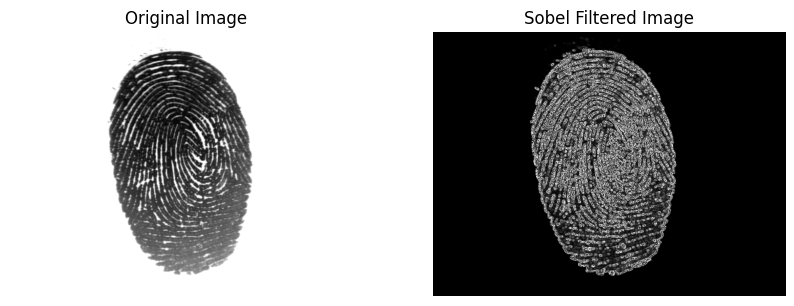

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image (grayscale)
image = cv2.imread('/content/fingerprint_datasets/DB1_B/DB1_B/110_2.tif', cv2.IMREAD_GRAYSCALE)

# Check if the image was loaded correctly
if image is None:
    print("Error: Image not found.")
    exit()

# Apply Sobel filter in the X direction (horizontal edges)
sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)

# Apply Sobel filter in the Y direction (vertical edges)
sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

# Calculate the magnitude of gradients (edge strength)
sobel_magnitude = cv2.magnitude(sobel_x, sobel_y)

# Convert the result to uint8 (for displaying properly)
sobel_magnitude = np.uint8(np.abs(sobel_magnitude))

# Display the original and Sobel-filtered images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(sobel_magnitude, cmap='gray')
plt.title('Sobel Filtered Image')
plt.axis('off')

plt.show()


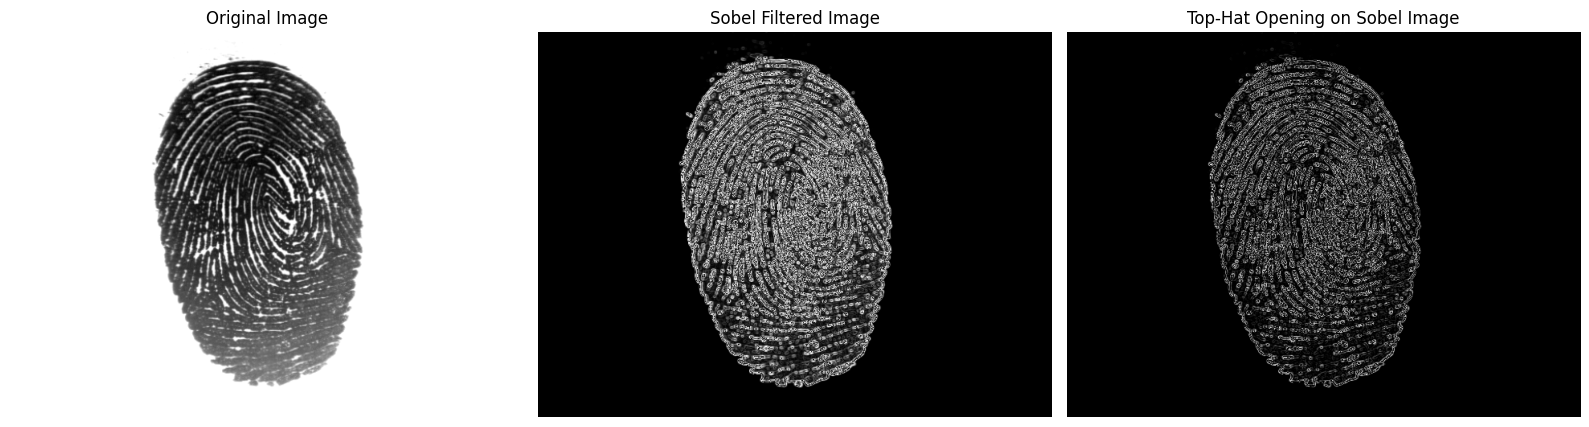

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image (grayscale)
image = cv2.imread('/content/fingerprint_datasets/DB1_B/DB1_B/110_2.tif', cv2.IMREAD_GRAYSCALE)

# Check if the image was loaded correctly
if image is None:
    print("Error: Image not found.")
    exit()

# Apply Sobel filter in the X direction (horizontal edges)
sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)

# Apply Sobel filter in the Y direction (vertical edges)
sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

# Calculate the magnitude of gradients (edge strength)
sobel_magnitude = cv2.magnitude(sobel_x, sobel_y)

# Convert the result to uint8 (for displaying properly)
sobel_magnitude = np.uint8(np.abs(sobel_magnitude))

# Define a kernel for morphological operations (a 3x3 kernel is common)
kernel = np.ones((3, 3), np.uint8)

# Apply the Closing operation (dilation followed by erosion) on the Sobel filtered image
closed_image = cv2.morphologyEx(sobel_magnitude, cv2.MORPH_CLOSE, kernel)

# Apply the Top-Hat transform on the result of Closing (original - closed image)
top_hat_closed_image = cv2.subtract(sobel_magnitude, closed_image)

# Apply the Opening operation (erosion followed by dilation) on the Sobel filtered image
opened_image = cv2.morphologyEx(sobel_magnitude, cv2.MORPH_OPEN, kernel)

# Apply the Top-Hat transform on the result of Opening (original - opened image)
top_hat_opened_image = cv2.subtract(sobel_magnitude, opened_image)

# Display the original, Sobel, Top-Hat Closing, and Top-Hat Opening images
plt.figure(figsize=(16, 8))

plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(sobel_magnitude, cmap='gray')
plt.title('Sobel Filtered Image')
plt.axis('off')

#plt.subplot(1, 4, 3)
#plt.imshow(top_hat_closed_image, cmap='gray')
#plt.title('Top-Hat Closing on Sobel Image')
#plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(top_hat_opened_image, cmap='gray')
plt.title('Top-Hat Opening on Sobel Image')
plt.axis('off')

plt.tight_layout()
plt.show()


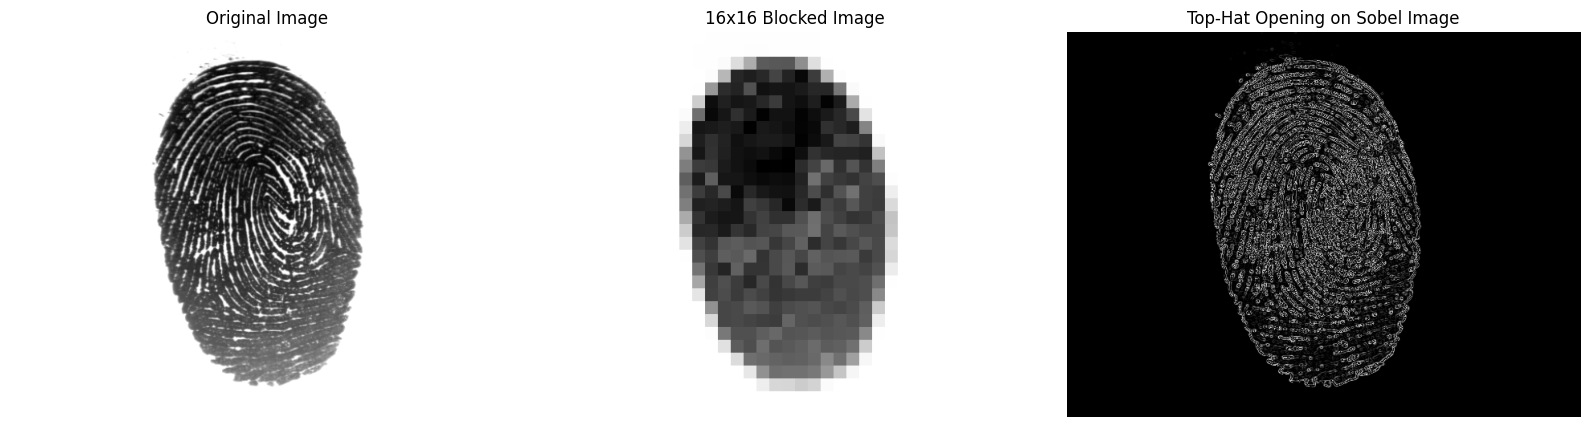

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image (grayscale)
image = cv2.imread('/content/fingerprint_datasets/DB1_B/DB1_B/110_2.tif', cv2.IMREAD_GRAYSCALE)

# Check if the image was loaded correctly
if image is None:
    print("Error: Image not found.")
    exit()

# Apply Sobel filter in the X direction (horizontal edges)
sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)

# Apply Sobel filter in the Y direction (vertical edges)
sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

# Calculate the magnitude of gradients (edge strength)
sobel_magnitude = cv2.magnitude(sobel_x, sobel_y)

# Convert the result to uint8 (for displaying properly)
sobel_magnitude = np.uint8(np.abs(sobel_magnitude))

# Define a kernel for morphological operations (a 3x3 kernel is common)
kernel = np.ones((3, 3), np.uint8)

# Apply the Opening operation (erosion followed by dilation) on the Sobel filtered image
opened_image = cv2.morphologyEx(sobel_magnitude, cv2.MORPH_OPEN, kernel)

# Apply the Top-Hat transform on the result of Opening (original - opened image)
top_hat_opened_image = cv2.subtract(sobel_magnitude, opened_image)

# Create 16x16 blocked version of the original image
def block_image(img, block_size=(16, 16)):
    h, w = img.shape
    block_h, block_w = block_size
    blocked_image = np.zeros_like(img)
    for y in range(0, h, block_h):
        for x in range(0, w, block_w):
            block = img[y:y+block_h, x:x+block_w]
            mean_val = np.mean(block)  # Use the average of the block
            blocked_image[y:y+block_h, x:x+block_w] = mean_val
    return blocked_image

blocked_image = block_image(image, block_size=(16, 16))

# Display the original, blocked, and Top-Hat Opening images
plt.figure(figsize=(16, 8))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Blocked Image (16x16 blocks)
plt.subplot(1, 3, 2)
plt.imshow(blocked_image, cmap='gray')
plt.title('16x16 Blocked Image')
plt.axis('off')

# Top-Hat Opening on Sobel Image
plt.subplot(1, 3, 3)
plt.imshow(top_hat_opened_image, cmap='gray')
plt.title('Top-Hat Opening on Sobel Image')
plt.axis('off')

plt.tight_layout()
plt.show()


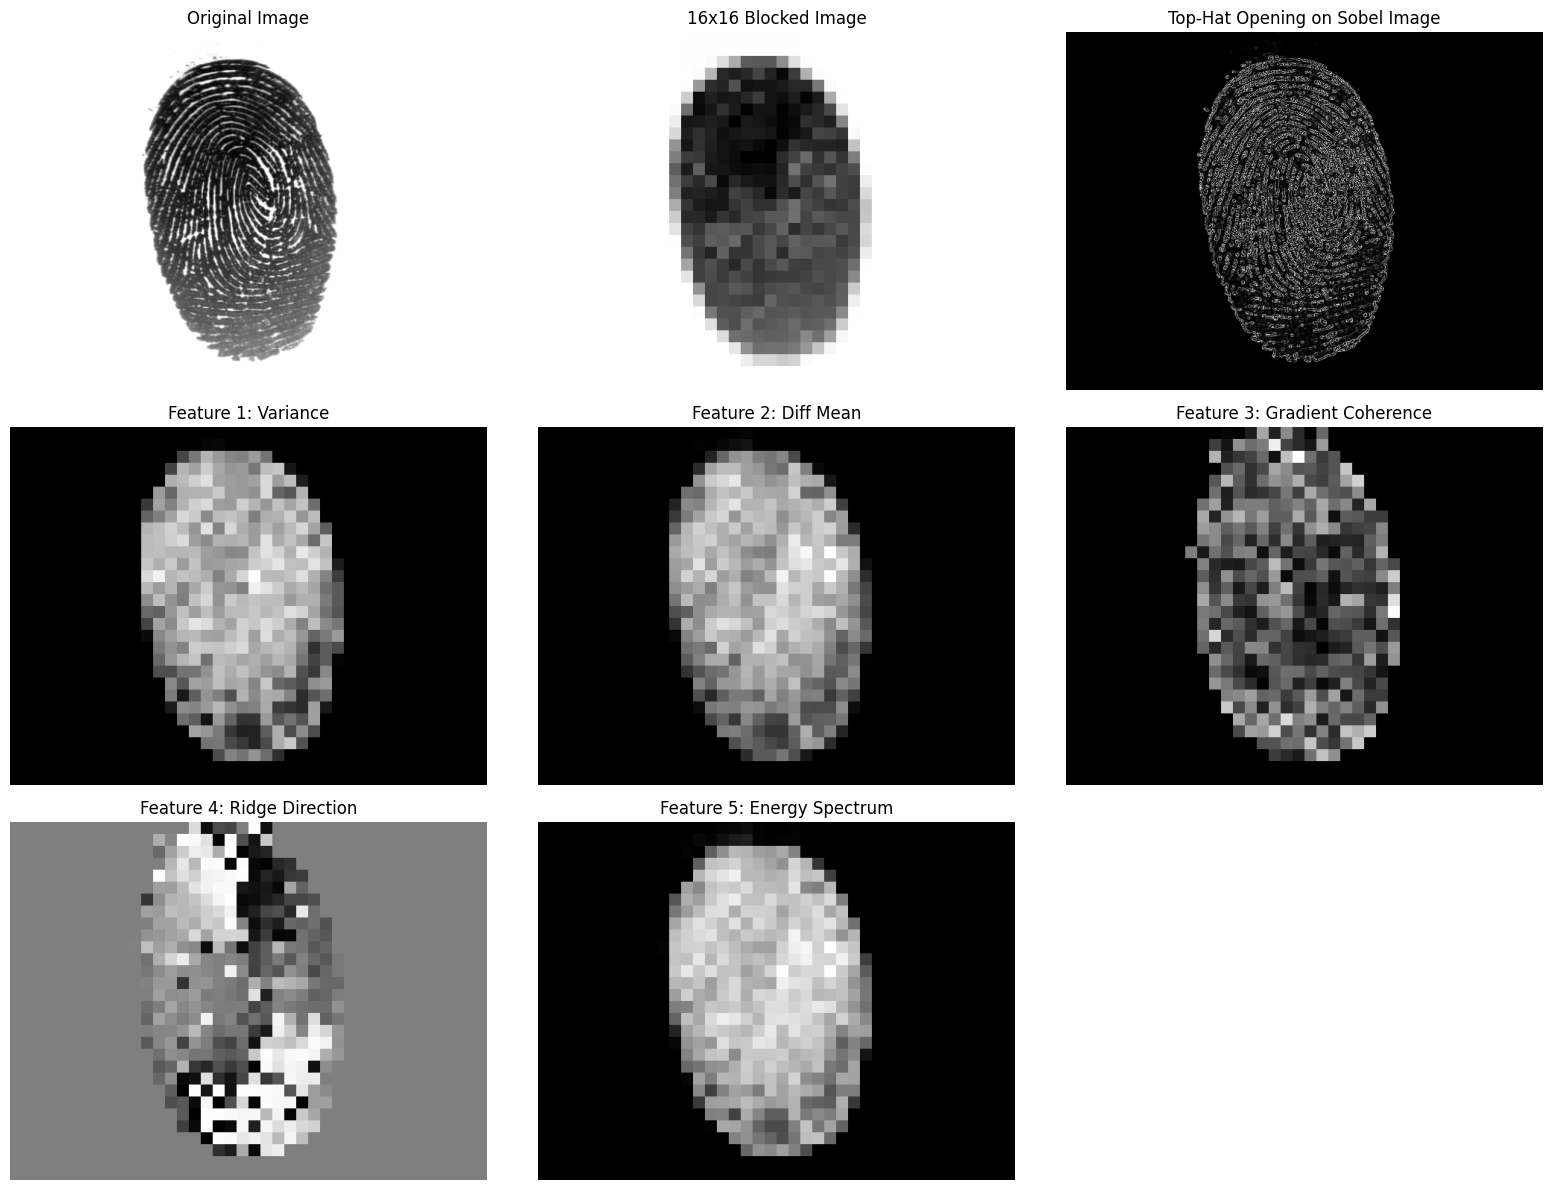

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image (grayscale)
image = cv2.imread('/content/fingerprint_datasets/DB1_B/DB1_B/110_2.tif', cv2.IMREAD_GRAYSCALE)

# Check if the image was loaded correctly
if image is None:
    print("Error: Image not found.")
    exit()

# Calculate global mean of the image
global_mean = np.mean(image)

# Apply Sobel filter in the X direction (horizontal edges)
sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)

# Apply Sobel filter in the Y direction (vertical edges)
sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

# Calculate the magnitude of gradients (edge strength)
sobel_magnitude = cv2.magnitude(sobel_x, sobel_y)

# Convert the result to uint8 (for displaying properly)
sobel_magnitude = np.uint8(np.abs(sobel_magnitude))

# Define a kernel for morphological operations (a 3x3 kernel is common)
kernel = np.ones((3, 3), np.uint8)

# Apply the Opening operation (erosion followed by dilation) on the Sobel filtered image
opened_image = cv2.morphologyEx(sobel_magnitude, cv2.MORPH_OPEN, kernel)

# Apply the Top-Hat transform on the result of Opening (original - opened image)
top_hat_opened_image = cv2.subtract(sobel_magnitude, opened_image)

# Create 16x16 blocked version of the original image
def block_image(img, block_size=(16, 16)):
    h, w = img.shape
    block_h, block_w = block_size
    blocked_image = np.zeros_like(img)
    for y in range(0, h, block_h):
        for x in range(0, w, block_w):
            block = img[y:y+block_h, x:x+block_w]
            mean_val = np.mean(block)  # Use the average of the block
            blocked_image[y:y+block_h, x:x+block_w] = mean_val
    return blocked_image

blocked_image = block_image(image, block_size=(16, 16))

# Feature extraction function
def extract_features(block, global_mean):
    """Extract features from a block."""
    # 1. Variance
    variance = np.var(block)

    # 2. Difference of Mean
    local_mean = np.mean(block)
    diff_mean = local_mean - global_mean

    # 3. Gradient Coherence
    sobelx = cv2.Sobel(block, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(block, cv2.CV_64F, 0, 1, ksize=3)
    gx2 = np.mean(sobelx**2)
    gy2 = np.mean(sobely**2)
    gxy = np.mean(sobelx * sobely)
    coherence = np.sqrt((gx2 - gy2)**2 + 4 * gxy**2) / (gx2 + gy2 + 1e-8)

    # 4. Ridge Direction
    ridge_direction = 0.5 * np.arctan2(2 * gxy, gx2 - gy2)

    # 5. Energy Spectrum (via Fourier transform)
    fft = np.fft.fft2(block)
    energy_spectrum = np.sqrt(np.sum(np.real(fft)**2 + np.imag(fft)**2))

    return [variance, diff_mean, coherence, ridge_direction, energy_spectrum]

# Prepare images to display each feature
feature_images = {
    'Variance': np.zeros_like(top_hat_opened_image, dtype=np.float32),
    'Diff Mean': np.zeros_like(top_hat_opened_image, dtype=np.float32),
    'Coherence': np.zeros_like(top_hat_opened_image, dtype=np.float32),
    'Ridge Direction': np.zeros_like(top_hat_opened_image, dtype=np.float32),
    'Energy Spectrum': np.zeros_like(top_hat_opened_image, dtype=np.float32)
}

# Block size for feature extraction
block_size = (16, 16)

# Extract features from blocks of the top-hat opened image
for y in range(0, top_hat_opened_image.shape[0], block_size[0]):
    for x in range(0, top_hat_opened_image.shape[1], block_size[1]):
        block = top_hat_opened_image[y:y + block_size[0], x:x + block_size[1]]
        features = extract_features(block, global_mean)

        # Fill feature images
        feature_images['Variance'][y:y + block_size[0], x:x + block_size[1]] = features[0]
        feature_images['Diff Mean'][y:y + block_size[0], x:x + block_size[1]] = features[1]
        feature_images['Coherence'][y:y + block_size[0], x:x + block_size[1]] = features[2]
        feature_images['Ridge Direction'][y:y + block_size[0], x:x + block_size[1]] = features[3]
        feature_images['Energy Spectrum'][y:y + block_size[0], x:x + block_size[1]] = features[4]

# Display the images
plt.figure(figsize=(16, 12))

# Original Image
plt.subplot(3, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Blocked Image (16x16 blocks)
plt.subplot(3, 3, 2)
plt.imshow(blocked_image, cmap='gray')
plt.title('16x16 Blocked Image')
plt.axis('off')

# Top-Hat Opening on Sobel Image
plt.subplot(3, 3, 3)
plt.imshow(top_hat_opened_image, cmap='gray')
plt.title('Top-Hat Opening on Sobel Image')
plt.axis('off')

# Feature 1: Variance
plt.subplot(3, 3, 4)
plt.imshow(feature_images['Variance'], cmap='gray')
plt.title('Feature 1: Variance')
plt.axis('off')

# Feature 2: Difference of Mean
plt.subplot(3, 3, 5)
plt.imshow(feature_images['Diff Mean'], cmap='gray')
plt.title('Feature 2: Diff Mean')
plt.axis('off')

# Feature 3: Gradient Coherence
plt.subplot(3, 3, 6)
plt.imshow(feature_images['Coherence'], cmap='gray')
plt.title('Feature 3: Gradient Coherence')
plt.axis('off')

# Feature 4: Ridge Direction
plt.subplot(3, 3, 7)
plt.imshow(feature_images['Ridge Direction'], cmap='gray')
plt.title('Feature 4: Ridge Direction')
plt.axis('off')

# Feature 5: Energy Spectrum
plt.subplot(3, 3, 8)
plt.imshow(feature_images['Energy Spectrum'], cmap='gray')
plt.title('Feature 5: Energy Spectrum')
plt.axis('off')

plt.tight_layout()
plt.show()


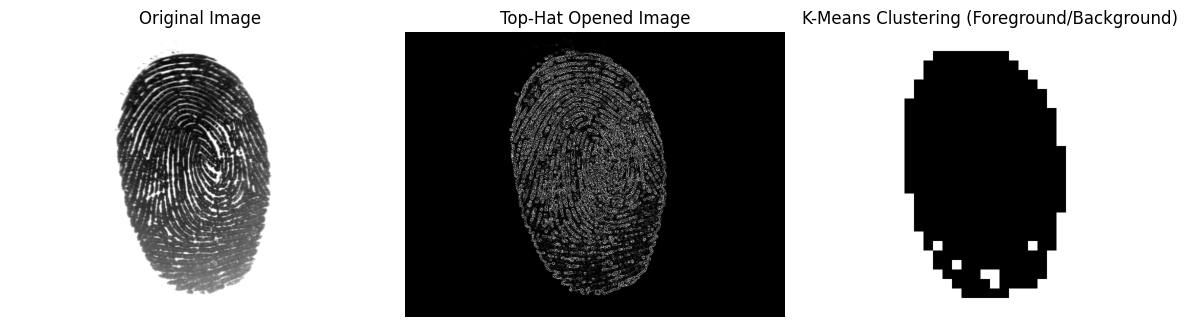

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Load image (grayscale)
image = cv2.imread('/content/fingerprint_datasets/DB1_B/DB1_B/110_2.tif', cv2.IMREAD_GRAYSCALE)

# Check if the image was loaded correctly
if image is None:
    print("Error: Image not found.")
    exit()

# Calculate global mean of the image
global_mean = np.mean(image)

# Apply Sobel filter in the X and Y directions
sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
sobel_magnitude = cv2.magnitude(sobel_x, sobel_y)
sobel_magnitude = np.uint8(np.abs(sobel_magnitude))

# Morphological operations
kernel = np.ones((3, 3), np.uint8)
opened_image = cv2.morphologyEx(sobel_magnitude, cv2.MORPH_OPEN, kernel)
top_hat_opened_image = cv2.subtract(sobel_magnitude, opened_image)

# Block size
block_size = (16, 16)

# Feature extraction function
def extract_features(block, global_mean):
    variance = np.var(block)
    local_mean = np.mean(block)
    diff_mean = local_mean - global_mean
    sobelx = cv2.Sobel(block, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(block, cv2.CV_64F, 0, 1, ksize=3)
    gx2 = np.mean(sobelx**2)
    gy2 = np.mean(sobely**2)
    gxy = np.mean(sobelx * sobely)
    coherence = np.sqrt((gx2 - gy2)**2 + 4 * gxy**2) / (gx2 + gy2 + 1e-8)
    ridge_direction = 0.5 * np.arctan2(2 * gxy, gx2 - gy2)
    fft = np.fft.fft2(block)
    energy_spectrum = np.sqrt(np.sum(np.real(fft)**2 + np.imag(fft)**2))
    return [variance, diff_mean, coherence, ridge_direction, energy_spectrum]

# Extract features and prepare for clustering
h, w = top_hat_opened_image.shape
feature_vectors = []
coordinates = []

for y in range(0, h, block_size[0]):
    for x in range(0, w, block_size[1]):
        block = top_hat_opened_image[y:y + block_size[0], x:x + block_size[1]]
        features = extract_features(block, global_mean)
        feature_vectors.append(features)
        coordinates.append((y, x))

# Convert feature vectors to numpy array
feature_vectors = np.array(feature_vectors)

# Apply K-Means clustering (2 clusters: foreground and background)
kmeans = KMeans(n_clusters=2, random_state=0).fit(feature_vectors)
labels = kmeans.labels_

# Reconstruct clustered image
clustered_image = np.zeros((h, w), dtype=np.uint8)

for idx, (y, x) in enumerate(coordinates):
    clustered_image[y:y + block_size[0], x:x + block_size[1]] = labels[idx] * 255  # Scale labels to 0 and 255

# Display the results
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Top-Hat Opening on Sobel Image
plt.subplot(1, 3, 2)
plt.imshow(top_hat_opened_image, cmap='gray')
plt.title('Top-Hat Opened Image')
plt.axis('off')

# Clustered Image
plt.subplot(1, 3, 3)
plt.imshow(clustered_image, cmap='gray')
plt.title('K-Means Clustering (Foreground/Background)')
plt.axis('off')

plt.tight_layout()
plt.show()


Label counts: Counter({0: 835, 1: 352, 2: 10, -1: 3})


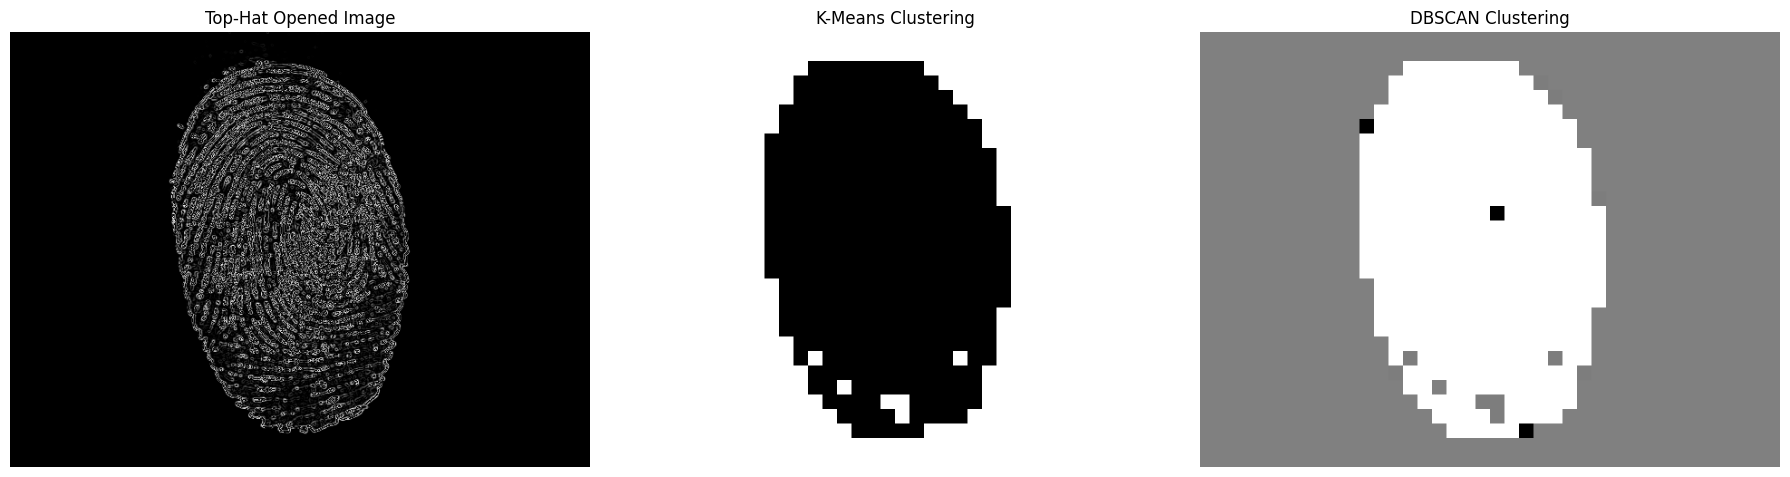

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

# Load image (grayscale)
image = cv2.imread('/content/fingerprint_datasets/DB1_B/DB1_B/110_2.tif', cv2.IMREAD_GRAYSCALE)

# Check if the image was loaded correctly
if image is None:
    print("Error: Image not found.")
    exit()

# Calculate global mean of the image
global_mean = np.mean(image)

# Apply Sobel filter in the X and Y directions
sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
sobel_magnitude = cv2.magnitude(sobel_x, sobel_y)
sobel_magnitude = np.uint8(np.abs(sobel_magnitude))

# Morphological operations
kernel = np.ones((3, 3), np.uint8)
opened_image = cv2.morphologyEx(sobel_magnitude, cv2.MORPH_OPEN, kernel)
top_hat_opened_image = cv2.subtract(sobel_magnitude, opened_image)

# Block size
block_size = (16, 16)

# Feature extraction function
def extract_features(block, global_mean):
    variance = np.var(block)
    local_mean = np.mean(block)
    diff_mean = local_mean - global_mean
    sobelx = cv2.Sobel(block, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(block, cv2.CV_64F, 0, 1, ksize=3)
    gx2 = np.mean(sobelx**2)
    gy2 = np.mean(sobely**2)
    gxy = np.mean(sobelx * sobely)
    coherence = np.sqrt((gx2 - gy2)**2 + 4 * gxy**2) / (gx2 + gy2 + 1e-8)
    ridge_direction = 0.5 * np.arctan2(2 * gxy, gx2 - gy2)
    fft = np.fft.fft2(block)
    energy_spectrum = np.sqrt(np.sum(np.real(fft)**2 + np.imag(fft)**2))
    return [variance, diff_mean, coherence, ridge_direction, energy_spectrum]

# Extract features and prepare for clustering
h, w = top_hat_opened_image.shape
feature_vectors = []
coordinates = []

for y in range(0, h, block_size[0]):
    for x in range(0, w, block_size[1]):
        block = top_hat_opened_image[y:y + block_size[0], x:x + block_size[1]]
        features = extract_features(block, global_mean)
        feature_vectors.append(features)
        coordinates.append((y, x))

# Convert feature vectors to numpy array
feature_vectors = np.array(feature_vectors)

# Apply K-Means clustering (2 clusters: foreground and background)
kmeans = KMeans(n_clusters=2, random_state=0).fit(feature_vectors)
labels_kmeans = kmeans.labels_

# Add K-Means labels as a feature
kmeans_feature = labels_kmeans * 255
feature_vectors_with_labels = np.hstack((feature_vectors[:,[0]], kmeans_feature.reshape(-1, 1)))

# Apply DBSCAN clustering on extended features
dbscan = DBSCAN(eps=200, min_samples=8).fit(feature_vectors_with_labels)
labels_dbscan = dbscan.labels_

# Map DBSCAN labels back to the image coordinates
clustered_image_dbscan = np.zeros((h, w), dtype=np.uint8)
for idx, (y, x) in enumerate(coordinates):
    if labels_dbscan[idx] != -1:  # Exclude noise points labeled as -1
        clustered_image_dbscan[y:y + block_size[0], x:x + block_size[1]] = (labels_dbscan[idx] + 1) * 127
from collections import Counter

# Count the occurrences of each label
label_counts = Counter(labels_dbscan)

# Print the counts for each label
print("Label counts:", label_counts)

# Map K-Means labels back to the image coordinates
clustered_image_kmeans = np.zeros((h, w), dtype=np.uint8)
for idx, (y, x) in enumerate(coordinates):
    clustered_image_kmeans[y:y + block_size[0], x:x + block_size[1]] = labels_kmeans[idx] * 255

# Display the results
plt.figure(figsize=(18, 6))

# Top-Hat Opening on Sobel Image
plt.subplot(1, 3, 1)
plt.imshow(top_hat_opened_image, cmap='gray')
plt.title('Top-Hat Opened Image')
plt.axis('off')

# K-Means Clustered Image
plt.subplot(1, 3, 2)
plt.imshow(clustered_image_kmeans, cmap='gray')
plt.title('K-Means Clustering')
plt.axis('off')

# DBSCAN Clustered Image
plt.subplot(1, 3, 3)
plt.imshow(clustered_image_dbscan, cmap='gray')
plt.title('DBSCAN Clustering')
plt.axis('off')

plt.tight_layout()
plt.show()


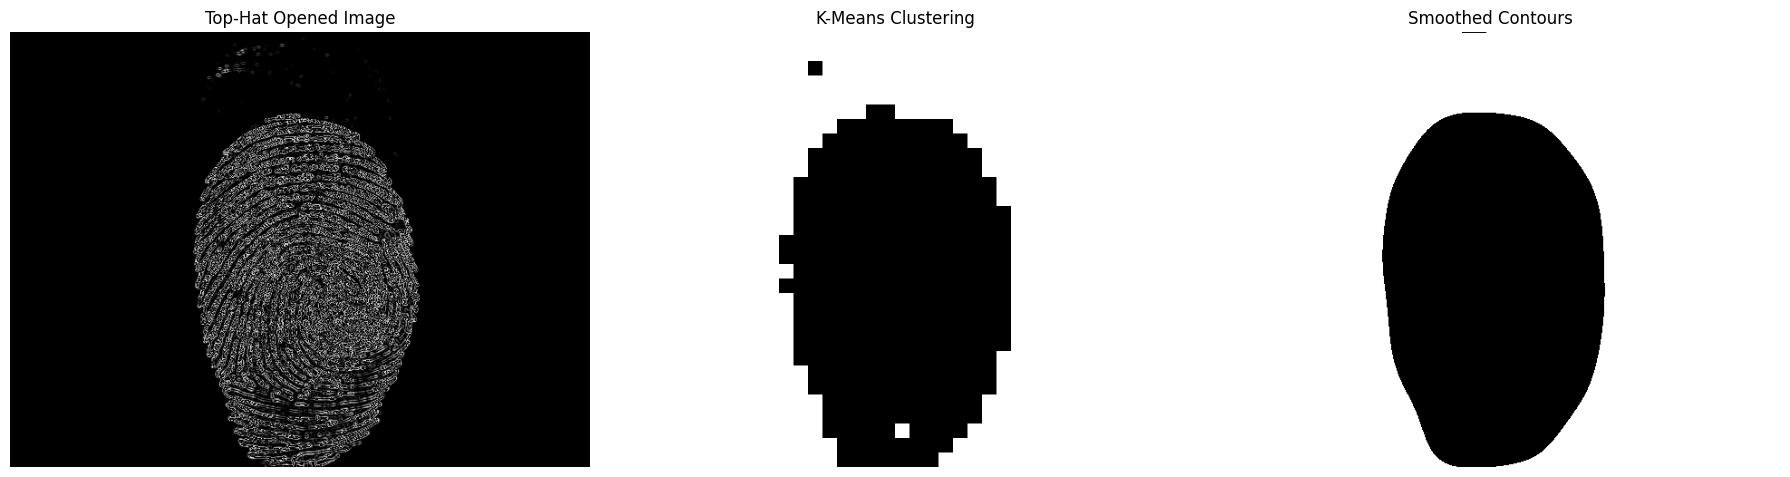

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Load image (grayscale)
image = cv2.imread('/content/fingerprint_datasets/DB1_B/DB1_B/110_2.tif', cv2.IMREAD_GRAYSCALE)

# Check if the image was loaded correctly
if image is None:
    print("Error: Image not found.")
    exit()

# Calculate global mean of the image
global_mean = np.mean(image)

# Apply Sobel filter in the X and Y directions
sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
sobel_magnitude = cv2.magnitude(sobel_x, sobel_y)
sobel_magnitude = np.uint8(np.abs(sobel_magnitude))

# Morphological operations
kernel = np.ones((3, 3), np.uint8)
opened_image = cv2.morphologyEx(sobel_magnitude, cv2.MORPH_OPEN, kernel)
top_hat_opened_image = cv2.subtract(sobel_magnitude, opened_image)

# Block size
block_size = (16, 16)

# Feature extraction function
def extract_features(block, global_mean):
    variance = np.var(block)
    local_mean = np.mean(block)
    diff_mean = local_mean - global_mean
    sobelx = cv2.Sobel(block, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(block, cv2.CV_64F, 0, 1, ksize=3)
    gx2 = np.mean(sobelx**2)
    gy2 = np.mean(sobely**2)
    gxy = np.mean(sobelx * sobely)
    coherence = np.sqrt((gx2 - gy2)**2 + 4 * gxy**2) / (gx2 + gy2 + 1e-8)
    ridge_direction = 0.5 * np.arctan2(2 * gxy, gx2 - gy2)
    fft = np.fft.fft2(block)
    energy_spectrum = np.sqrt(np.sum(np.real(fft)**2 + np.imag(fft)**2))
    return [variance, diff_mean, coherence, ridge_direction, energy_spectrum]

# Extract features and prepare for clustering
h, w = top_hat_opened_image.shape
feature_vectors = []
coordinates = []

for y in range(0, h, block_size[0]):
    for x in range(0, w, block_size[1]):
        block = top_hat_opened_image[y:y + block_size[0], x:x + block_size[1]]
        features = extract_features(block, global_mean)
        feature_vectors.append(features)
        coordinates.append((y, x))

# Convert feature vectors to numpy array
feature_vectors = np.array(feature_vectors)

# Apply K-Means clustering (2 clusters: foreground and background)
kmeans = KMeans(n_clusters=2, random_state=0).fit(feature_vectors)
labels_kmeans = kmeans.labels_

# Add K-Means labels as a feature
kmeans_feature = labels_kmeans * 255
feature_vectors_with_labels = np.hstack((feature_vectors[:,[0]], kmeans_feature.reshape(-1, 1)))

# Map K-Means labels back to the image coordinates
clustered_image_kmeans = np.zeros((h, w), dtype=np.uint8)
for idx, (y, x) in enumerate(coordinates):
    clustered_image_kmeans[y:y + block_size[0], x:x + block_size[1]] = labels_kmeans[idx] * 255

# Contour smoothing function
def smooth_contours(mask, cutoff=5):
    """Smooth the contours of the binary mask using filtering in the Fourier transform domain."""
    mask = (mask > 0).astype(np.uint8)
    f_transform = np.fft.fft2(mask)
    f_shift = np.fft.fftshift(f_transform)
    rows, cols = mask.shape
    crow, ccol = rows // 2, cols // 2
    mask_filter = np.zeros((rows, cols), np.uint8)
    cv2.circle(mask_filter, (ccol, crow), cutoff, 1, -1)
    f_shift_filtered = f_shift * mask_filter
    f_ishift = np.fft.ifftshift(f_shift_filtered)
    smoothed = np.fft.ifft2(f_ishift)
    smoothed = np.abs(smoothed)
    smoothed = (smoothed > 0.5).astype(np.uint8) * 255
    return smoothed

# Apply contour smoothing to the K-Means clustered image
smoothed_contours_image = smooth_contours(clustered_image_kmeans)

# Display the results
plt.figure(figsize=(18, 6))

# Top-Hat Opening on Sobel Image
plt.subplot(1, 3, 1)
plt.imshow(top_hat_opened_image, cmap='gray')
plt.title('Top-Hat Opened Image')
plt.axis('off')

# K-Means Clustered Image
plt.subplot(1, 3, 2)
plt.imshow(clustered_image_kmeans, cmap='gray')
plt.title('K-Means Clustering')
plt.axis('off')

# Smoothed Contours Image
plt.subplot(1, 3, 3)
plt.imshow(smoothed_contours_image, cmap='gray')
plt.title('Smoothed Contours')
plt.axis('off')

plt.tight_layout()
plt.show()


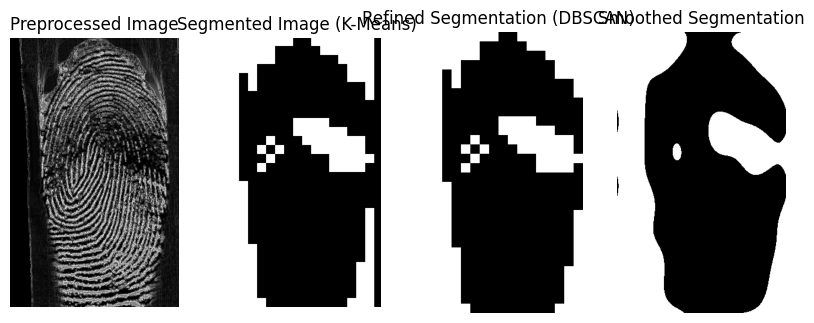

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

# Feature extraction function
def extract_features(block):
    """Extract features from a block."""
    # 1. Variance
    variance = np.var(block)

    # 2. Difference of Mean
    local_mean = np.mean(block)
    global_mean = np.mean(block.flatten())
    diff_mean = local_mean - global_mean

    # 3. Gradient Coherence
    sobelx = cv2.Sobel(block, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(block, cv2.CV_64F, 0, 1, ksize=3)
    gx2 = np.mean(sobelx**2)
    gy2 = np.mean(sobely**2)
    gxy = np.mean(sobelx * sobely)
    coherence = np.sqrt((gx2 - gy2)**2 + 4 * gxy**2) / (gx2 + gy2 + 1e-8)

    # 4. Ridge Direction
    ridge_direction = 0.5 * np.arctan2(2 * gxy, gx2 - gy2)

    # 5. Energy Spectrum (via Fourier transform)
    fft = np.fft.fft2(block)
    energy_spectrum = np.sqrt(np.sum(np.real(fft)**2 + np.imag(fft)**2))

    return [variance, diff_mean, coherence, ridge_direction, energy_spectrum]

# Preprocessing function
def preprocess_image(image):
    """Preprocess the image using Sobel and TopHat filters."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Sobel Filters
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    gradient = np.sqrt(sobelx**2 + sobely**2)
    gradient = np.uint8(gradient)

    # TopHat Filter
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
    tophat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, kernel)

    preprocessed = cv2.addWeighted(gradient, 0.5, tophat, 0.5, 0)

    return preprocessed

# Segment image and get K-Means labels
def segment_image_with_kmeans(image, block_size=16):
    """Segment the image into foreground and background and return K-Means labels."""
    h, w = image.shape
    features = []
    locations = []

    # Extract features for each block
    for y in range(0, h, block_size):
        for x in range(0, w, block_size):
            block = image[y:y + block_size, x:x + block_size]
            if block.shape == (block_size, block_size):  # Ensure block size is consistent
                features.append(extract_features(block))
                locations.append((y, x))

    # Apply K-Means
    kmeans = KMeans(n_clusters=2, random_state=42)
    labels = kmeans.fit_predict(features)

    # Create a binary mask based on clustering
    mask = np.zeros(image.shape, dtype=np.uint8)
    for idx, (y, x) in enumerate(locations):
        if labels[idx] == 1:  # Adjust label index if needed
            mask[y:y + block_size, x:x + block_size] = 255

    return mask, labels, locations

# DBSCAN refinement function based on block locations
def refine_segmentation_with_dbscan(labels, locations, block_size, eps=30, min_samples=5):
    """
    Refine segmentation using DBSCAN based on block locations only.
    Blocks with similar K-Means labels and close proximity are grouped.
    """
    # Convert locations to numerical array
    locations = np.array(locations)

    # Apply DBSCAN
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(locations)
    db_labels = db.labels_

    # Create refined mask
    refined_mask = np.zeros((block_size * (max(y for y, x in locations) // block_size + 1),
                             block_size * (max(x for y, x in locations) // block_size + 1)), dtype=np.uint8)

    for idx, label in enumerate(db_labels):
        if label != -1:  # Ignore noise
            y, x = locations[idx]
            if labels[idx] == 1:  # Ensure K-Means label is foreground
                refined_mask[y:y + block_size, x:x + block_size] = 255

    return refined_mask

# Contour smoothing function
def smooth_contours(mask, cutoff=5):
    """Smooth the contours of the binary mask using filtering in the Fourier transform domain."""
    mask = (mask > 0).astype(np.uint8)
    f_transform = np.fft.fft2(mask)
    f_shift = np.fft.fftshift(f_transform)
    rows, cols = mask.shape
    crow, ccol = rows // 2, cols // 2
    mask_filter = np.zeros((rows, cols), np.uint8)
    cv2.circle(mask_filter, (ccol, crow), cutoff, 1, -1)
    f_shift_filtered = f_shift * mask_filter
    f_ishift = np.fft.ifftshift(f_shift_filtered)
    smoothed = np.fft.ifft2(f_ishift)
    smoothed = np.abs(smoothed)
    smoothed = (smoothed > 0.5).astype(np.uint8) * 255
    return smoothed

# Main pipeline function
def fingerprint_segmentation_pipeline(input_image_path):
    """Complete fingerprint segmentation pipeline."""
    input_image = cv2.imread(input_image_path)
    if input_image is None:
        print(f"Error: Unable to load image {input_image_path}")
        return

    # Step 1: Preprocessing
    preprocessed = preprocess_image(input_image)
    plt.figure(figsize=(10, 8))
    plt.subplot(141)
    plt.imshow(preprocessed, cmap='gray')
    plt.title("Preprocessed Image")
    plt.axis('off')

    # Step 2: Segmentation and K-Means labels
    segmentation, kmeans_labels, locations = segment_image_with_kmeans(preprocessed, block_size=16)
    plt.subplot(142)
    plt.imshow(segmentation, cmap='gray')
    plt.title("Segmented Image (K-Means)")
    plt.axis('off')

    # Step 3: DBSCAN Refinement
    refined_segmentation = refine_segmentation_with_dbscan(kmeans_labels, locations, block_size=16, eps=30, min_samples=5)
    plt.subplot(143)
    plt.imshow(refined_segmentation, cmap='gray')
    plt.title("Refined Segmentation (DBSCAN)")
    plt.axis('off')

    # Step 4: Contour Smoothing
    smoothed_segmentation = smooth_contours(refined_segmentation, cutoff=5)
    plt.subplot(144)
    plt.imshow(smoothed_segmentation, cmap='gray')
    plt.title("Smoothed Segmentation")
    plt.axis('off')

    # Show the result
    plt.show()

# Test the function on one image
input_image_path = '/content/fingerprint_datasets/DB3_B/DB3_B/108_8.tif'  # Change this path to your image
fingerprint_segmentation_pipeline(input_image_path)


In [ ]:
# Main pipeline function
def fingerprint_segmentation_pipeline(image_path):
    """Complete fingerprint segmentation pipeline."""
    input_image = cv2.imread(image_path)
    if input_image is None:
        print(f"Error: Unable to load image {image_path}")
        return

    # Preprocessing
    gray, gradient, tophat, preprocessed = preprocess_image(input_image)
    plot_steps([gray, gradient, tophat, preprocessed],
               ['Gray Image', 'Gradient', 'TopHat Filter', 'Preprocessed Image'])

    # Segmentation
    segmentation = segment_image(preprocessed, block_size=16)
    plot_steps([segmentation], ['Segmented Image'])

    # Smooth Contours
    smoothed_segmentation = smooth_contours(segmentation)
    plot_steps([smoothed_segmentation], ['Smoothed Segmentation'])

    # Invert the smoothed segmentation
    inverted_mask = cv2.bitwise_not(smoothed_segmentation)
    plot_steps([inverted_mask], ['Inverted Mask'])

    # Apply inverted mask to original image
    masked_image = cv2.multiply(gray, inverted_mask, scale=1/255.0)  # Scale needed for proper blending
    plot_steps([gray, smoothed_segmentation, inverted_mask, masked_image],
               ['Original Image', 'Smoothed Segmentation', 'Inverted Mask', 'Final Masked Image'])

# Run the pipeline on a single image
image_path = '/content/fingerprint_datasets/DB1_B/DB1_B/104_4.tif'  # Update with your image path
fingerprint_segmentation_pipeline(image_path)


ValueError: too many values to unpack (expected 4)